In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, assemble
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram

from pymatching import Matching
import numpy as np

In [2]:
def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    # eg = pauli_error([('X',p_gate), ('I', 1 - p_gate)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    # noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_gate1, ["id"])
    return noise_model

In [3]:
class RepQubit:
	def __init__(self, d = 3, reps = 1):
		self.qr = QuantumRegister(d, name='qr')
		self.c = ClassicalRegister(d, name='c')
		self.nqr = d
		self.nanc = d-1
		self.anc = QuantumRegister(self.nanc, name='anc')
		self.link = []
		for i in range(reps):
			self.link.append(ClassicalRegister(self.nanc, name=f'link_{i}_qr'))
		# self.syn = ClassicalRegister(self.nanc * reps, name='syn')
		self.circ = QuantumCircuit(self.qr, self.c, self.anc, *self.link)
		self.reps = reps


	def draw(self):
		return self.circ.draw()

	def entangle(self):
		for i in range(1, self.nqr):
			self.circ.cx(self.qr[0], self.qr[i])
		self.circ.barrier()

	def stabilise(self, i = 0):
		self.circ.barrier()
		for x in range(self.nqr):
			self.circ.id(self.qr[x])
			# self.circ.x(self.qr[x])
		self.circ.barrier()
		for x in range(self.nqr-1):
			self.circ.cx(self.qr[x],self.anc[x])
			self.circ.cx(self.qr[x+1],self.anc[x])
		self.circ.barrier()
		self.circ.measure(self.anc, self.link[i])
		# self.circ.measure(self.anc, self.syn())
		# self.circ.reset(self.anc)
		# self.circ.barrier()
		# self.circ
		# print(self.syn.instances_c)

In [4]:
qubit = RepQubit(3)
qubit.stabilise(0)
qubit.circ.measure(qubit.qr, qubit.c)
print(qubit.draw())
counts = execute(
    qubit.circ, 
    Aer.get_backend('qasm_simulator'), 
    noise_model=get_noise(0, 0.05), 
    optimization_level=0,
    shots=1000
).result().get_counts()
print(counts)



              ░ ┌───┐ ░                      ░       ┌─┐      
       qr_0: ─░─┤ I ├─░───■──────────────────░───────┤M├──────
              ░ ├───┤ ░   │                  ░       └╥┘┌─┐   
       qr_1: ─░─┤ I ├─░───┼────■────■────────░────────╫─┤M├───
              ░ ├───┤ ░   │    │    │        ░        ║ └╥┘┌─┐
       qr_2: ─░─┤ I ├─░───┼────┼────┼────■───░────────╫──╫─┤M├
              ░ └───┘ ░ ┌─┴─┐┌─┴─┐  │    │   ░ ┌─┐    ║  ║ └╥┘
      anc_0: ─░───────░─┤ X ├┤ X ├──┼────┼───░─┤M├────╫──╫──╫─
              ░       ░ └───┘└───┘┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐ ║  ║  ║ 
      anc_1: ─░───────░───────────┤ X ├┤ X ├─░──╫─┤M├─╫──╫──╫─
              ░       ░           └───┘└───┘ ░  ║ └╥┘ ║  ║  ║ 
        c: 3/═══════════════════════════════════╬══╬══╩══╩══╩═
                                                ║  ║  0  1  2 
                                                ║  ║          
link_0_qr: 2/═══════════════════════════════════╩══╩══════════
                                                0  1   

In [5]:
class RepDecoder:
	def __init__(self, d,p_meas, p_gate):
		hzl = []
		for i in range(d-1):
			row = [0]*d; row[i] = 1; row[i+1] = 1
			hzl.append(row)
		self.Hz = np.array(hzl)
		# print(f'Hz: {self.Hz}')
		self.d = d
		self.match = Matching(
			self.Hz,
			# spacelike_weights=np.log((1-p_gate)/p_gate),
			# repetitions=1,
			# timelike_weights=np.log((1-p_meas)/p_meas)
		)
		# Matching.add_noise()
		# self.match.draw()

	def correct(self, out, syn):
		c = self.match.decode(syn)
		return (out + c)%2

	def getlogbit(self, readout):
		s = sum(readout)
		if 2*s <= self.d:
			return 0
		else:
			return 1

In [6]:
def testrep(d, reps, p_meas, p_gate):
    qubit = RepQubit(d, reps)
    for i in range(reps):
        qubit.stabilise(i)
    qubit.circ.measure(qubit.qr, qubit.c)
    # print(qubit.draw())
    SHOTS = 10000
    counts = execute(
		qubit.circ, 
		Aer.get_backend('qasm_simulator'), 
		noise_model=get_noise(p_meas, p_gate), 
		optimization_level=0,
		shots=SHOTS
	).result().get_counts()

    decoder = RepDecoder(d, p_meas, p_gate)
    errcnt = 0
    # print(counts)
    for bitstr in counts:
        meas = bitstr.split()
        # print(bitstr)
        out = np.array(list(map(int, [*meas[-1]])))
        syn = np.array(list(map(int, [*meas[0]])))

        out = decoder.correct(out, syn)
        outbit = decoder.getlogbit(out)
        if outbit != 0:
            errcnt += counts[bitstr]

    perr = errcnt / SHOTS; print(perr)
    return perr


In [7]:
qubit = RepQubit(3)
qubit.stabilise(0)
qubit.circ.measure(qubit.qr, qubit.c)
print(qubit.draw())
counts = execute(
    qubit.circ, 
    Aer.get_backend('qasm_simulator'), 
    noise_model=get_noise(0, 0.05), 
    optimization_level=0,
    shots=1000
).result().get_counts()
print(counts)


decoder = RepDecoder(3, 0.01, 0.05)
errcnt = 0
# print(counts)
for bitstr in counts:
    meas = bitstr.split()
    # print(bitstr)
    out = np.array(list(map(int, [*meas[-1]])))
    syn = np.array(list(map(int, [*meas[0]])))

    out = decoder.correct(out, syn)
    outbit = decoder.getlogbit(out)
    print(outbit)

              ░ ┌───┐ ░                      ░       ┌─┐      
       qr_0: ─░─┤ I ├─░───■──────────────────░───────┤M├──────
              ░ ├───┤ ░   │                  ░       └╥┘┌─┐   
       qr_1: ─░─┤ I ├─░───┼────■────■────────░────────╫─┤M├───
              ░ ├───┤ ░   │    │    │        ░        ║ └╥┘┌─┐
       qr_2: ─░─┤ I ├─░───┼────┼────┼────■───░────────╫──╫─┤M├
              ░ └───┘ ░ ┌─┴─┐┌─┴─┐  │    │   ░ ┌─┐    ║  ║ └╥┘
      anc_0: ─░───────░─┤ X ├┤ X ├──┼────┼───░─┤M├────╫──╫──╫─
              ░       ░ └───┘└───┘┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐ ║  ║  ║ 
      anc_1: ─░───────░───────────┤ X ├┤ X ├─░──╫─┤M├─╫──╫──╫─
              ░       ░           └───┘└───┘ ░  ║ └╥┘ ║  ║  ║ 
        c: 3/═══════════════════════════════════╬══╬══╩══╩══╩═
                                                ║  ║  0  1  2 
                                                ║  ║          
link_0_qr: 2/═══════════════════════════════════╩══╩══════════
                                                0  1   

0.001
0.0324
0.0951
0.1709
0.2535
0.3266
0.3903
0.4358
0.4815
0.4961
0.0007
0.0325
0.0875
0.1656
0.2459
0.3184
0.3846
0.4428
0.4788
0.4937
0.001
0.0352
0.0974
0.1653
0.2497
0.3175
0.3897
0.4351
0.4655
0.5028


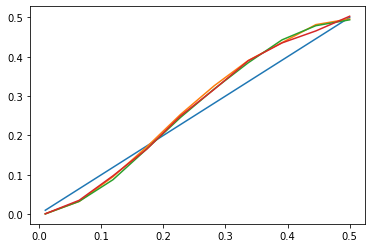

In [8]:
# testrep(3, 1, 0, 0.05)
xv = np.linspace(0.01, 0.5, 10)
yvs = []
plt.plot(xv, xv)
for i in range(3, 8, 2):
    yv = [testrep(i, 1, p, p) for p in xv]
    plt.plot(xv, yv)
# plt.plot(xv, yv)